Approach: As I'm new to these concepts, directly tackling a large project seemed overwhelming. Therefore, I started with a simple Convolutional Neural Network (CNN) model that classifies the CIFAR-10 dataset. After gaining some experience, I progressed to this more advanced project.

This project involves a CNN model based on ResNet50 with additional customized layers added at the end. The model is trained on the VOC2012 dataset to identify objects and predict their bounding boxes. Since the model performs both classification and localization simultaneously, it requires two targets during training: the class of the object and its bounding box. After training on a substantial amount of data, the model can detect the class of objects and draw bounding boxes around them.

Note: This code takes a considerable amount of time to run. Feel free to adjust the steps per epoch and the number of epochs as needed.

At the end of this document, I've also included my learnings about Vision Transformers, their performance compared to CNNs, and the scenarios in which each technique excels.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Dropout, UpSampling2D, Add, Concatenate,GlobalAveragePooling2D,BatchNormalization
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Below Two cells of code which is required to read and proccess the image before uploading to our model , I got it from ChatGPT , But I know what each line of code does. For understanding this code I used online resources and websites

An example of XML document is shown below. It contains a root node and many children nodes for it. Each node may contain some information about the image




In [2]:
#         <annotation>
#             <folder>VOC2012</folder>
#             <filename>2007_000027.jpg</filename>
#             <source>
#                 <database>The VOC2007 Database</database>
#                 <annotation>PASCAL VOC2007</annotation>
#                 <image>flickr</image>
#             </source>
#             <size>
#                 <width>486</width>
#                 <height>500</height>
#                 <depth>3</depth>
#             </size>
#             <segmented>0</segmented>
#             <object>
#                 <name>person</name>
#                 <pose>Unspecified</pose>
#                 <truncated>0</truncated>
#                 <difficult>0</difficult>
#                 <bndbox>
#                     <xmin>174</xmin>
#                     <ymin>101</ymin>
#                     <xmax>349</xmax>
#                     <ymax>351</ymax>
#                 </bndbox>
#                 <part>
#                     <name>head</name>
#                     <bndbox>
#                         <xmin>169</xmin>
#                         <ymin>104</ymin>
#                         <xmax>209</xmax>
#                         <ymax>146</ymax>
#                     </bndbox>
#                 </part>
#                 <part>
#                     <name>hand</name>
#                     <bndbox>
#                         <xmin>278</xmin>
#                         <ymin>210</ymin>
#                         <xmax>297</xmax>
#                         <ymax>233</ymax>
#                     </bndbox>
#                 </part>
#                 <part>
#                     <name>foot</name>
#                     <bndbox>
#                         <xmin>273</xmin>
#                         <ymin>333</ymin>
#                         <xmax>297</xmax>
#                         <ymax>354</ymax>
#                     </bndbox>
#                 </part>
#                 <part>
#                     <name>foot</name>
#                     <bndbox>
#                         <xmin>319</xmin>
#                         <ymin>307</ymin>
#                         <xmax>340</xmax>
#                         <ymax>326</ymax>
#                     </bndbox>
#                 </part>
#             </object>
#         </annotation>


In [3]:
def parse_xml_annotation(xml_file_path):
    tree = ET.parse(xml_file_path) # this will fetch you the hierarchial tree present in the XML node
    root = tree.getroot() # this will take you to the root node of the XML document
    labels = []
    bboxes = []
    for obj in root.findall('object'): # iterating through the elements and identifying the name and bounding box 
        # (which is nothing but a rectangular frame surrounding the object)
        label = obj.find('name').text
        labels.append(label)
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        bboxes.append([xmin, ymin, xmax, ymax])
    return labels, bboxes

In [4]:
import os
import random

def load_images_with_labels(image_directory, annotation_directory, batch_size, target_size, num_classes=20, subset_size=None):
    image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory)]
    
    if subset_size is not None:
        image_paths = random.sample(image_paths, subset_size)
    
    annotation_paths = [os.path.join(annotation_directory, os.path.splitext(os.path.basename(image_path))[0] + ".xml")
                        for image_path in image_paths]
    
    while True:
        #np.random.shuffle(image_paths)
        for i in range(0, len(image_paths), batch_size):
            batch_image_paths = image_paths[i:i+batch_size]
            batch_images = []
            batch_labels = []
            batch_bboxes = []
            for image_path in batch_image_paths:
                image_id = os.path.splitext(os.path.basename(image_path))[0]
                xml_file_path = os.path.join(annotation_directory, f"{image_id}.xml")
                if os.path.exists(xml_file_path):
                    labels, bboxes = parse_xml_annotation(xml_file_path)
                    label_vector = np.zeros(num_classes)
                    for label in labels:
                        if label in VOC_CLASSES:
                            label_index = VOC_CLASSES.index(label)
                            label_vector[label_index] = 1
                    batch_labels.append(label_vector)
                    batch_bboxes.append(bboxes[0] if bboxes else [0, 0, 0, 0])
                    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
                    image = tf.keras.preprocessing.image.img_to_array(image)
                    batch_images.append(image)
            if batch_images:
                yield np.array(batch_images), [np.array(batch_bboxes), np.array(batch_labels)]


import numpy as np

def load_images_with_labels_test(image_directory, annotation_directory, target_size, num_classes=20, subset_size=None):
    image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory)]
    
    if subset_size is not None:
        image_paths = random.sample(image_paths, subset_size)
    
    annotation_paths = [os.path.join(annotation_directory, os.path.splitext(os.path.basename(image_path))[0] + ".xml")
                        for image_path in image_paths]
    
    images = []
    labels = []
    bboxes = []
    
    for image_path, annotation_path in zip(image_paths, annotation_paths):
        image_id = os.path.splitext(os.path.basename(image_path))[0]
        if os.path.exists(annotation_path):
            labels_, bboxes_ = parse_xml_annotation(annotation_path)
            label_vector = np.zeros(num_classes)
            for label in labels_:
                if label in VOC_CLASSES:
                    label_index = VOC_CLASSES.index(label)
                    label_vector[label_index] = 1
            labels.append(label_vector)
            bboxes.append(bboxes_[0] if bboxes_ else [0, 0, 0, 0])
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
    
    return np.array(images), [np.array(bboxes), np.array(labels)]


image_directory = "D:/VOC_2012 dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages"
annotation_directory = "D:/VOC_2012 dataset/VOC2012_train_val/VOC2012_train_val/Annotations"
image_directory_test = "D:\VOC_2012 dataset\VOC2012_test\VOC2012_test\JPEGImages"
annotation_directory_test = "D:\VOC_2012 dataset\VOC2012_test\VOC2012_test\Annotations"
batch_size = 16
target_size = (224, 224)
num_classes = 20
VOC_CLASSES = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

# Specify the size of the subset you want to load
subset_size = 17125 # Choose an appropriate subset size max is 17125
subset_size_test = 5000 # max size of testset is 16135
# Load images and labels with the modified function, passing the subset_size argument
image_generator = load_images_with_labels(image_directory, annotation_directory, batch_size=batch_size, target_size=target_size, subset_size=subset_size)
image_generator_test = load_images_with_labels_test(image_directory_test, annotation_directory_test,  target_size=target_size, num_classes=num_classes, subset_size=subset_size_test)

In [5]:
batch_images, batch_labels = next(image_generator)
output_dir = r'D:\AIC_question\output\training_output'
# Print out the shapes of the fetched data to verify
print(f'Batch images shape: {batch_images.shape}')
print(f'Batch bounding boxes shape: {batch_labels[0].shape}')
print(f'Batch class labels shape: {batch_labels[1].shape}')

for j in range(16):  # Single batch has 16 images
    image = np.array(batch_images[j], dtype=np.uint8)
    plt.imshow(image)
    plt.axis('off')
    image_filename = os.path.join(output_dir, f'image_{j}.png')
    plt.savefig(image_filename, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f'Image {j} saved as {image_filename}')
    print('Image array:', batch_images[j])
    print('Bounding box:', batch_labels[0][j])
    print('Class label:', batch_labels[1][j], "--> one_hot_encoded")
    for i in range(20):
        if batch_labels[1][j][i] == 1:
            print(f'Class: {VOC_CLASSES[i]}')

Batch images shape: (16, 224, 224, 3)
Batch bounding boxes shape: (16, 4)
Batch class labels shape: (16, 20)
Image 0 saved as D:\AIC_question\output\training_output\image_0.png
Image array: [[[  8.  28.  19.]
  [  6.  36.   0.]
  [ 65. 117.  43.]
  ...
  [102. 105. 124.]
  [  0.  13.  19.]
  [  5.  31.  20.]]

 [[ 11.  34.   6.]
  [  6.  42.   0.]
  [ 49. 103.  17.]
  ...
  [ 23.  39.  36.]
  [ 12.  28.  43.]
  [ 29.  50.  67.]]

 [[ 23.  48.  19.]
  [ 42.  79.  27.]
  [ 43.  91.   7.]
  ...
  [ 33.  59.  58.]
  [ 50.  71.  90.]
  [ 77.  96. 136.]]

 ...

 [[198. 193. 190.]
  [209. 204. 201.]
  [223. 219. 216.]
  ...
  [162. 154. 135.]
  [189. 181. 158.]
  [158. 151. 122.]]

 [[205. 200. 197.]
  [199. 194. 191.]
  [215. 211. 208.]
  ...
  [195. 191. 164.]
  [174. 168. 142.]
  [166. 159. 130.]]

 [[199. 195. 192.]
  [218. 214. 211.]
  [213. 209. 206.]
  ...
  [178. 173. 144.]
  [177. 172. 143.]
  [167. 162. 132.]]]
Bounding box: [163 127 301 327]
Class label: [0. 0. 0. 0. 0. 0. 0. 0. 0.

Uncomment the below cell to view those printed images in your notebook itself

In [6]:
# batch_images, batch_labels = next(image_generator)

# # Print out the shapes of the fetched data to verify
# print(f'Batch images shape: {batch_images.shape}')
# print(f'Batch bounding boxes shape: {batch_labels[0].shape}')
# print(f'Batch class labels shape: {batch_labels[1].shape}')# as the classes of the images are one hot encoded , and we have 
# # twenty classes shape of class labels is 16*20 , where 16 is the batch size. and for the bounding box , we have four corners and
# # as it is an recangle , coordinates of two corners is alone enough. one of them is max and the other is diagonally opposite to
# # it , min.
# for j in range(16):#single batch has 16 images so let's print all of them
#     image = np.array(batch_images[j], dtype=np.uint8)
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()
#     print('First image array:', batch_images[0])
#     print('First bounding box:', batch_labels[0][0])
#     print('First class label:', batch_labels[1][0],"-->one_hot_encoded")
#     for i in range(20):
#         if batch_labels[1][j][i]==1:
#             print(VOC_CLASSES[i])

In [7]:
# Load ResNet50 base model
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False
# # Flatten the output of the base model. make it into an one dimensional array.
# flatten = Flatten()(base_model.output)
# x = Dense(1024, activation='relu')(flatten)
# x = Dropout(0.5)(x)
# bbox_output = Dense(4, activation='linear', name='bbox_output')(x)
# class_output = Dense(num_classes, activation='softmax', name='class_output')(x)
# model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])

Trying with another set of modified final layers

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)
class_output = Dense(num_classes, activation='softmax', name='class_output')(x)
model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])

as there are no in built function to evaluate our model (for the bounding box especially) with the test case we have to define our own functions to evaluate our 
model with metrics such as precision , recall and mean average precision 

In [9]:
def iou(box1, box2):
# in this box1 and box2 contains the coordinates of the corners of the bounding box, one of them is predicted boundingbox and 
# and the other is the actual bounding box and we are measuring the common region between them ,and from that we will measure
# the union of those two bounding boxes and it's ratio will give us the desired factor.
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    return iou

def average_precision(y_true, y_pred,iou_threshold=0.5):
    if len(y_true) == 0 or len(y_pred) == 0:
        return 0, 0, 0
    
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for i in range(len(y_true)):
        matched = False 
        for j in range(len(y_pred)):
            iou_score = iou(y_true[i], y_pred[j])
            if iou_score > iou_threshold:
                true_positive += 1
                matched = True  
                break  
        if not matched:
            false_negative += 1  
    false_positive = len(y_pred) - true_positive

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    ap = precision * recall if precision > 0 and recall > 0 else 0
    return ap, recall, precision
def mean_average_precision(y_true, y_pred, iou_threshold=0.5 ):
    aps = []
    recalls = []
    precisions = []
    for i in range(len(y_true)):
        ap, recall, precision = average_precision(y_true[i], y_pred[i][1:], iou_threshold)
        aps.append(ap)
        recalls.append(recall)
        precisions.append(precision)
    
    return np.mean(aps), np.mean(recalls), np.mean(precisions)

def accuracy(y_true, y_pred):
    correct = 0
    total = len(y_true)
    
    for true_label, pred_label in zip(y_true, y_pred):
        if np.argmax(true_label) == np.argmax(pred_label):
            correct += 1
    
    return correct / total

def evaluate_model(image_generator_test, model):
    global y_true_labels
    images, [bboxes, y_true_labels] = image_generator_test
    
    y_pred_boxes = [[0] for _ in range(20)]
    global y_pred_class
    y_pred_class = []
    for image in images:
        image = np.expand_dims(image, axis=0)
        print(image.shape)
        pred = model.predict(image)
        
        # Assuming the model output format needs to be reshaped for bounding boxes
        pred_class = pred[1]
        pred_box = pred[0]# Adjust based on model output format
        y_pred_class.append(pred_class[0])
        index = np.where(pred_class[0] == np.max(pred_class[0]))
        y_pred_boxes[index[0][0]].append(pred_box[0])
    bboxes_final = [[] for _ in range(20)]
    for i in range(len(bboxes)):
        index_box = np.where(y_true_labels[i] == np.max(y_true_labels[i]))
        bboxes_final[index_box[0][0]].append(bboxes[i])
    mAP, recall, precision = mean_average_precision(bboxes_final, y_pred_boxes)
    accuracy_score = accuracy(y_true_labels, y_pred_class)

    return mAP, recall, precision, accuracy_score

In [10]:
# Compile the model with appropriate loss functions and metrics
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={'bbox_output': 'mean_squared_error', 'class_output': 'categorical_crossentropy'},
              metrics={'bbox_output': 'mean_absolute_error', 'class_output': 'accuracy'})


In [11]:
# Summary of the model
# in the below summary of the model , last five layers are customly added and remaining belongs to the RESNET50 model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [12]:
# Train the model using the image generator
model.fit(image_generator, steps_per_epoch=100, epochs=10)

Epoch 1/10


100/100 [==============================] - 97s 905ms/step - loss: 70402.4141 - bbox_output_loss: 70398.3516 - class_output_loss: 4.0623 - bbox_output_mean_absolute_error: 221.2827 - class_output_accuracy: 0.2894
Epoch 2/10
100/100 [==============================] - 101s 1s/step - loss: 64490.6758 - bbox_output_loss: 64487.5469 - class_output_loss: 3.1479 - bbox_output_mean_absolute_error: 210.6566 - class_output_accuracy: 0.4913
Epoch 3/10
100/100 [==============================] - 102s 1s/step - loss: 48695.0039 - bbox_output_loss: 48691.8047 - class_output_loss: 3.1987 - bbox_output_mean_absolute_error: 178.6007 - class_output_accuracy: 0.5306
Epoch 4/10
100/100 [==============================] - 102s 1s/step - loss: 28252.7559 - bbox_output_loss: 28248.9805 - class_output_loss: 3.7680 - bbox_output_mean_absolute_error: 132.3576 - class_output_accuracy: 0.5006
Epoch 5/10
100/100 [==============================] - 99s 986ms/step - loss: 14834.6533 - bbox_output_loss: 1483

In the VOC2012 test set, annotations are available only for images containing the "person" class. Unfortunately, this limitation prevents us from evaluating our model's performance across all classes. Although our model is capable of identifying other object classes, we cannot include these in our evaluation metrics due to the lack of corresponding ground truth annotations in the test set.

In [13]:
mAP, recall, precision, accuracy_score = evaluate_model(image_generator_test, model)
print(f"Mean Average Precision (mAP): {mAP}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Classification Accuracy: {accuracy_score}")

(1, 224, 224, 3)
1/1 [==============================] - 3s 3s/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 203ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 213ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 174ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 223ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 180ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 158ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 262ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 263ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 227ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 138ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 197ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 156ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 210ms/step
(1, 224, 224, 3)
1/1 [=

However, you can manually inspect how well the model performs by visualizing the predictions on a subset of test images. Feel free to change the number of test images to be printed for manual inspection.

In [15]:
images, [bboxes, y_true_labels] = image_generator_test
output_dir = r'D:\AIC_question\output\test_output'
for i in range(20):
    # Expand dimensions to match model input shape
    image = np.expand_dims(images[i], axis=0)
    
    # Predict
    pred = model.predict(image)
    pred_class = pred[1]
    
    # Get indices of predicted and actual classes
    j = np.where(pred_class[0] == np.max(pred_class[0]))[0][0]
    k = np.where(y_true_labels[i] == np.max(y_true_labels[i]))[0][0]
    
    # Convert image to uint8 for visualization
    image_print = np.array(image[0], dtype=np.uint8)
    
    # Save the image
    image_filename = os.path.join(output_dir, f'image_{i}.png')
    plt.imshow(image_print)
    plt.axis('off')
    plt.savefig(image_filename, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to avoid display
    
    print(f'Image {i} saved as {image_filename}')
    print(f"Predicted Class: {VOC_CLASSES[j]} ")
    print(f"Actual Class: {VOC_CLASSES[k]}")

1/1 [==============================] - 1s 1s/step
Image 0 saved as D:\AIC_question\output\test_output\image_0.png
Predicted Class: person 
Actual Class: person
1/1 [==============================] - 0s 276ms/step
Image 1 saved as D:\AIC_question\output\test_output\image_1.png
Predicted Class: person 
Actual Class: person
1/1 [==============================] - 0s 223ms/step
Image 2 saved as D:\AIC_question\output\test_output\image_2.png
Predicted Class: person 
Actual Class: person
1/1 [==============================] - 0s 202ms/step
Image 3 saved as D:\AIC_question\output\test_output\image_3.png
Predicted Class: person 
Actual Class: person
1/1 [==============================] - 0s 230ms/step
Image 4 saved as D:\AIC_question\output\test_output\image_4.png
Predicted Class: person 
Actual Class: person
1/1 [==============================] - 0s 237ms/step
Image 5 saved as D:\AIC_question\output\test_output\image_5.png
Predicted Class: person 
Actual Class: person
1/1 [====================

In [16]:
# images, [bboxes, y_true_labels] = image_generator_test
# for i in range(20):
#     image = np.expand_dims(images[i], axis=0)
#     pred = model.predict(image)
#     pred_class = pred[1]
#     image_print = np.array(image[0], dtype=np.uint8)
#     j = np.where(pred_class[0] == np.max(pred_class[0]))[0][0]
#     k =np.where(y_true_labels[i] == np.max(y_true_labels[i]))[0][0]
#     plt.imshow(image_print)
#     plt.axis('off')
#     plt.show()
#     print(f"Predicted Class:{VOC_CLASSES[j]} ")
#     print(f"Actual Class:{VOC_CLASSES[k]}")

The classification accuracy of the model is quite good, but the precision and recall for the bounding boxes are not up to the mark. There could be several reasons for this:

        Lack of Training: The model might require more training to improve its performance.

        Freezing the ResNet Layers: I had to restrict the ResNet layers from being trained because training these layers requires a significant amount of memory, which my laptop's GPU cannot handle.

        Dataset Quality: While the model works well as a classifier, it struggles with drawing accurate bounding boxes. This might indicate that the dataset is not sufficient for training a model for this task. The dataset might lack diversity (e.g., images with different zoom levels, cropping, etc.), and data augmentation could help improve performance.

        Memory Constraints: I couldn't use other datasets due to memory limitations on my laptop.
        To improve the model's performance, the following steps could be taken:

        Unfreezing the ResNet Layers: Training the ResNet layers could potentially enhance performance, albeit requiring more computational resources.

        Data Augmentation: Applying data augmentation techniques to increase the diversity of the training data.

        Using More Powerful Hardware: Leveraging a more powerful GPU to handle larger datasets and more complex training.

Challenges Faced

        Memory Issues: As this is my first time building a CNN model, I encountered significant memory issues with large datasets. I initially started with the COCO dataset but had to switch to the VOC dataset due to its smaller size. I hope to find ways to handle large datasets in the future.

        Syntax and Code: Understanding the syntax and structure of the code was challenging. I used ChatGPT 3.5 for assistance with the syntax, but the algorithm, architecture, and overall idea are my own.
        Despite these challenges, I managed to build and train the model. With more time and better resources, I believe the model's performance, especially for drawing bounding boxes, can be significantly improved.

*SECOND PART*

Transformers are architectures primarily used in Natural Language Processing (NLP) due to their computational efficiency and scalability. In the research paper titled "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", the authors discuss how Vision Transformers (ViTs) can be used for object detection. However, the key disadvantage is that their performance is exceptional only when pre-trained on a large dataset.
https://www.youtube.com/watch?v=wjZofJX0v4M
This YouTube video clearly explains how transformers are used for NLP. Similarly, we can use transformers for object detection by representing patches of images (pixel by pixel RGB values) instead of word embeddings. These patches are then passed through an attention layer, which contains many weight matrices to check the relationships between different image patches. After that, the data is passed through a multilayer perceptron (MLP), a type of neural network.

This combination of an attention layer with MLP is repeated multiple times before producing the output. However, as mentioned earlier, Vision Transformers need to be pre-trained on a large dataset to perform well.

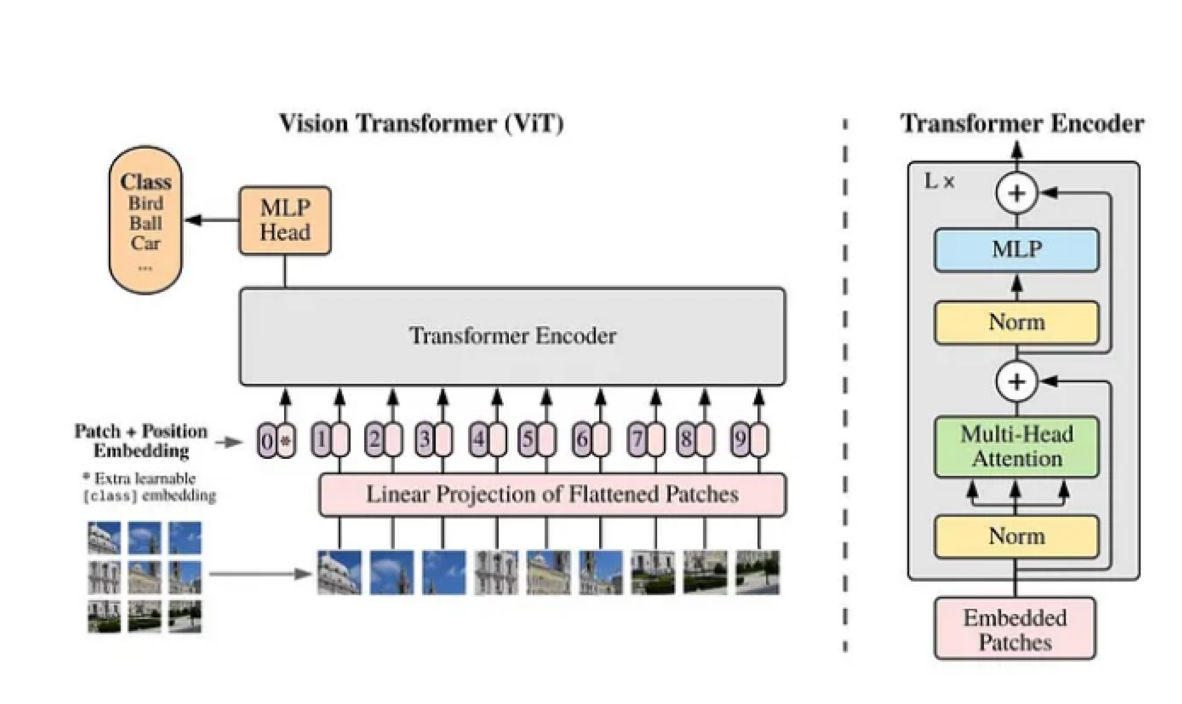

In [17]:
# Read the image
image_path = "vision transformers.png"
image = mpimg.imread(image_path)
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()


The model starts by dividing a 2D image into smaller fixed-size patches, like cutting the image into a grid of squares. Each of these patches is then flattened into a single line of data. Think of this as turning each patch into a string of numbers.

These strings of numbers are then transformed into a consistent size using a trainable linear projection, which means each patch is now represented as a vector of the same length. To make sure the model knows where each patch is in the original image, positional information is added to these vectors.

These vectors are then fed into a transformer encoder. This encoder has multiple layers of self-attention mechanisms, which allow the model to look at relationships between all patches. This means it can understand the context of the whole image by looking at how different patches relate to each other.

In addition to the patch vectors, a special token for classification is added. This token interacts with all the other patches through the self-attention layers and ends up containing information about the entire image.

The final output from the transformer encoder includes embeddings for each patch and the classification token. The embedding corresponding to the classification token is then used to represent the entire image.

This representation is passed to a classification head, usually a simple neural network, to make the final classification. This part can be fine-tuned on a specific dataset to improve its performance for a particular task.

Vision Transformers rely on this process of converting images into patches and using self-attention to understand the global context of the image. They often perform better when they are pre-trained on large datasets, as this helps them learn useful features that can be adapted to specific tasks through fine-tuning.

CNNs have been performing exceptionally well in many computer vision tasks and handle large-scale datasets efficiently. However, Vision Transformers offer significant advantages in scenarios where understanding global dependencies and context is crucial. This means they excel at tasks where the relationship between different parts of an image, even those far apart, is important.

For example, in a large image, a small detail in one corner might be influenced by another detail in the opposite corner. Vision Transformers can capture these long-distance relationships better than CNNs.*(global_dependencies)*

However, Vision Transformers require large datasets to train effectively. They perform as well as CNNs only when trained on extensive datasets, making them less suitable for situations with limited data.

https://medium.com/@faheemrustamy/vision-transformers-vs-convolutional-neural-networks-5fe8f9e18efc